In [68]:
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

sys.path.insert(0,'../lib')

import detection_tools as dt
import detection_preprocessing as dp
import strategy_detection_pose as sdp
import mle_sparse_est as mse
import parameters

import strategy_detection_pose as sd


In [69]:
sys.path.insert(0,'../../MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube
from mpdaf.obj import CubeDisk

from mpdaf.sdetect import Source, SourceList

In [70]:
# Version information
version = 1.4
# source dir
nom_dossier='./results/sources/'

In [71]:
def plot_directions(angle, intensite,pas):
    
    S0 = angle.shape[0]
    S1 = angle.shape[1]
    
    y,x = np.ogrid[0:S0,0:S1]
    

    deb_x = np.tile(x,(S0,1)) - 0.5*np.sin(angle) * intensite
    deb_y = np.tile(y,(1,S1)) - 0.5*np.cos(angle) * intensite
    
    fin_x = np.tile(x,(S0,1)) + 0.5*np.sin(angle) * intensite
    fin_y = np.tile(y,(1,S1)) + 0.5*np.cos(angle) * intensite
    
    
    for i in range(int(pas/2.),S0,pas):
        for j in range(int(pas/2.),S1,pas):
            if angle[i,j] != 0:
                plt.plot((deb_x[i,j],fin_x[i,j]), (deb_y[i,j],fin_y[i,j]) ,'k')
    plt.xlim((-0.5,S1-0.5))
    plt.ylim((-0.5,S0-0.5))     

In [72]:
def get_cubes(np_cube):

    Y_src = np_cube

    ss_cube_medfilt = si.medfilt(Y_src,(1,1,301))
    Y_ms = np_cube - ss_cube_medfilt

    ############
    # Ensuring Y_src cube is "square" (after median filtering + subcube extraction - preserving wcs)
    diff_size = Y_src.shape[0]-Y_src.shape[1]
    if diff_size!=0:
        taille = max( Y_src.shape[0],Y_src.shape[1])

        Y_src_new = np.zeros((taille,taille,Y_src.shape[2])) + np.nan
        Y_ms_new = np.zeros((taille,taille,Y_ms.shape[2])) + np.nan

        Y_src_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_src
        Y_ms_new[:Y_src.shape[0],:Y_src.shape[1],:] = Y_ms

        Y_src = Y_src_new
        Y_ms = Y_ms_new
    ############ 
    
    return Y_src,Y_ms

In [73]:
#empty_cube = cube.get_np_data()[750:770,50:130,35:75]
#empty_cube_border =  cube.get_np_data()[750:770,50:130,:40]
#empty_cube_sky = cube.get_np_data()[3000:3020,50:130,35:75]

#np.savez(file="../data/empty_cubes.npz",empty_cube=ma.getdata(empty_cube),empty_cube_border=ma.getdata(empty_cube_border),empty_cube_sky=ma.getdata(empty_cube_sky))

In [76]:
lambda_0 = 4750    # see Bacon et al, 2015
lambda_lya = 1216
pas_spectral = 1.25 # Angstrom / spectral band

W = 20
W_aff = 300
S = 50

    # Method parameters


In [77]:
def afficher(texte):
    plt.figure(figsize=(12,4))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    amax = Y_src[~np.isnan(Y_src)].max()/10
    plt.suptitle(texte, bbox=props,fontsize=14)

    plt.subplot(131)
    plt.imshow(Y_src.mean(axis=2),origin='lower',interpolation='nearest',cmap=plt.cm.gray_r,vmin=0,vmax=amax)
    plt.title('White Image')
    if printgal ==True:
        plt.contour(im_gal>im_gal.mean(),1,colors='r')
        plt.title('White image \n+ synthetic galaxy (red)')
    if printhalo ==True and printgal==True:
        plt.contour(im_gal>im_gal.mean(),1,colors='r')
        plt.contour(im_halo>im_halo.mean(),1,colors='b')
        plt.title('White image + \n synthetic galaxy (red), halo (blue)')
    plt.ylim((0,40))    
        
    plt.subplot(132)
    plt.imshow(Y_src[:,:,10:15].mean(axis=2),origin='lower',interpolation='nearest',cmap=plt.cm.gray_r,vmin=0,vmax=amax)
    plt.contour(X_init,1,colors='r')
    if res.sum()>0:
        plt.contour(res,1,colors='b')
    plt.title('NB image + initial (red) \n and extended blue) detections')
    plt.ylim((0,40))
    
    plt.subplot(133)
    plt.imshow(val,origin='lower',interpolation='nearest',cmap=plt.cm.Blues,vmin=0)
    plt.title('Detection statistic map + \n $10^{-4} \leq P_{\mathrm{FA}} \leq 10^{-1}$ contour')
    ksi = st.chi2.isf(PFA,df=X_init.sum()*10)
    plt.contour(val,ksi)
    plt.ylim((0,40))
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

In [78]:
def gen_simu_snr(bruit,gal,im_gal,halo,im_halo,snr,obj_princ):

    c = int(S/2)
    if obj_princ == 'halo':
        s = halo[c,c,:]
    else:
        s = gal[c,c,:]
        
    # Estimated covariance matrix.    
    liste_bruit = np.reshape(bruit,(bruit.shape[0]*bruit.shape[1],W))
    sigma = np.cov(liste_bruit[~np.isnan(liste_bruit).all(1)],rowvar=0)

    # Observed SNR
    snr_init = 10.*np.log10((np.linalg.norm(s)**2)/np.trace(sigma))

    # Differential SNR calculus:
    snr_cible = snr
    snr_diff = snr_cible-snr_init

    # Differential SNR, not in dB:
    snr_diff_dec = np.sqrt(10.**(snr_diff/10.))

    gal = gal * (im_gal[:,:,np.newaxis]>0)
    
    
    # Actual mixing of galaxy, halo, noise.
    if obj_princ == 'gal':
         Y_out = snr_diff_dec*gal + bruit
    else:
        halo = halo * (im_halo[:,:,np.newaxis]>0)
        Y_out = snr_diff_dec*(halo + gal) + bruit
    
    return Y_out

In [79]:
confident = True # CHoix ou non d'une marge de securite.

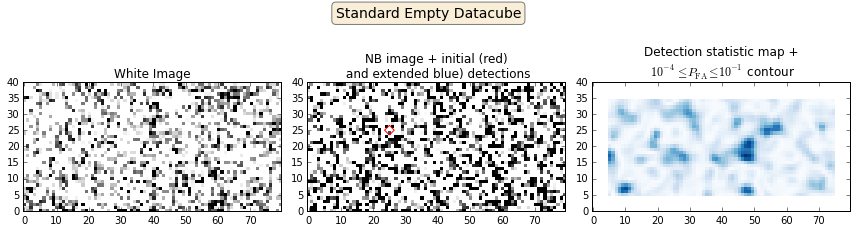

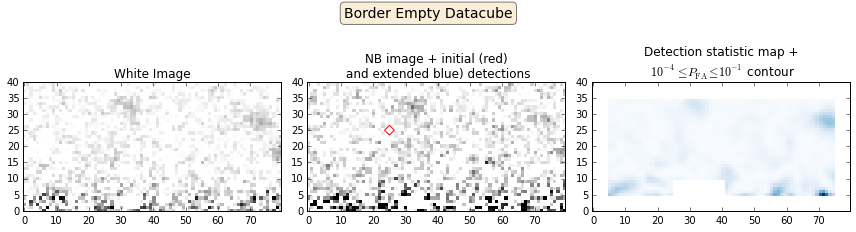

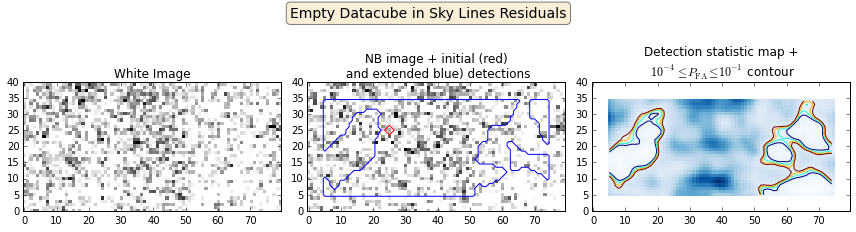

In [81]:
printgal = 0 
printhalo = 0
################################
### Standard Empty Cube

Y_src,Y_ms = get_cubes(empty_cube)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Standard Empty Datacube')


################################
### Border Empty Cube

Y_src,Y_ms = get_cubes(empty_cube_border)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Border Empty Datacube')

################################
### Standard Empty Cube in sky substraction residuals

Y_src,Y_ms = get_cubes(empty_cube_sky)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Empty Datacube in Sky Lines Residuals')


In [86]:
### Now we also insert artificial sources
dat = np.load('../data/simu_H-3.npz')
gal = dat['gal'] ; 
im_gal = gal.mean(axis=2)>gal.mean(); 
im_gal = im_gal[:40,:40] ;gal = gal[:40,:40, 5:25] ;

snr_gal = -5 # dB

empty_cube_gal = np.copy(empty_cube); empty_cube_gal[:,:40,:40] = gen_simu_snr(empty_cube_gal[:,:40,:40], gal,im_gal,0,0,snr=snr_gal,obj_princ='gal')
empty_cube_border_gal = np.copy(empty_cube_border); empty_cube_border_gal[:,:40,:40] =  gen_simu_snr(empty_cube_border_gal[:,:40,:40], gal,im_gal,0,0,snr=snr_gal,obj_princ='gal')
empty_cube_sky_gal = np.copy(empty_cube_sky); empty_cube_sky_gal[:,:40,:40] =  gen_simu_snr(empty_cube_sky_gal[:,:40,:40], gal,im_gal,0,0,snr=snr_gal,obj_princ='gal')

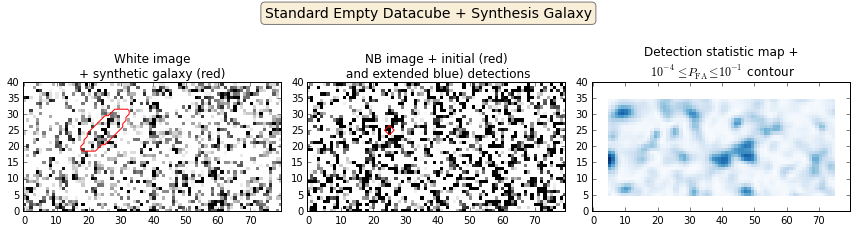

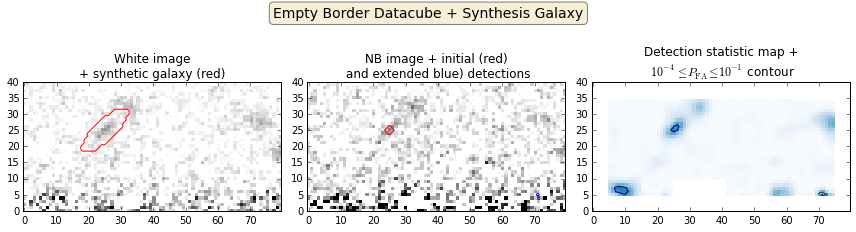

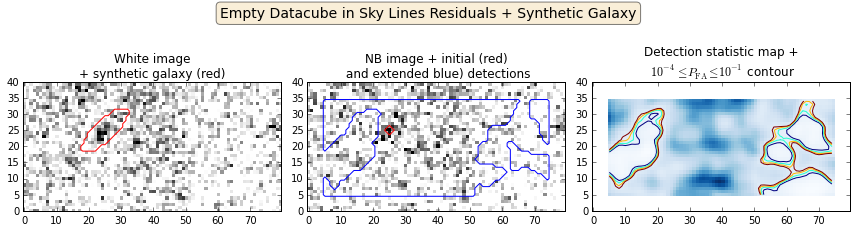

In [87]:
printgal = True
printhalo = False
################################
### Standard Empty Cube + galaxy inserted

Y_src,Y_ms = get_cubes(empty_cube_gal)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)
afficher('Standard Empty Datacube + Synthesis Galaxy')

################################
### Standard Empty Cube + galaxy inserted
Y_src,Y_ms = get_cubes(empty_cube_border_gal)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Empty Border Datacube + Synthesis Galaxy')

################################
### Standard Empty Cube + galaxy inserted
Y_src,Y_ms = get_cubes(empty_cube_sky_gal)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Empty Datacube in Sky Lines Residuals + Synthetic Galaxy')


In [84]:
### Now we also insert artificial sources + a halo
dat = np.load('../data/simu_H-3.npz')
halo = dat['halo'] ; 
im_halo = halo.mean(axis=2)>halo.mean(); 
im_halo = im_halo[:40,:40] ; halo =10* halo[:40,:40, 5:25] 
snr_halo = -10# dB

empty_cube_all = np.copy(empty_cube_gal); empty_cube_all[:,:40,:40] = gen_simu_snr(empty_cube_all[:,:40,:40], gal,im_gal,halo,im_halo,snr=snr_halo,obj_princ='halo')
empty_cube_border_all = np.copy(empty_cube_border_gal); empty_cube_border_all[:,:40,:40] = gen_simu_snr(empty_cube_border_all[:,:40,:40], gal,im_gal,halo,im_halo,snr=snr_halo,obj_princ='halo')
empty_cube_sky_all = np.copy(empty_cube_sky_gal); empty_cube_sky_all[:,:40,:40]= gen_simu_snr(empty_cube_sky_all[:,:40,:40], gal,im_gal,halo,im_halo,snr=snr_halo,obj_princ='halo')

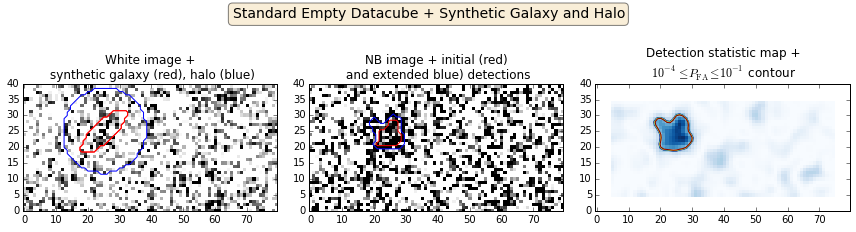

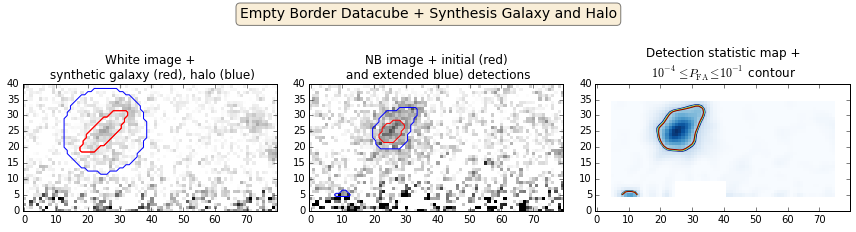

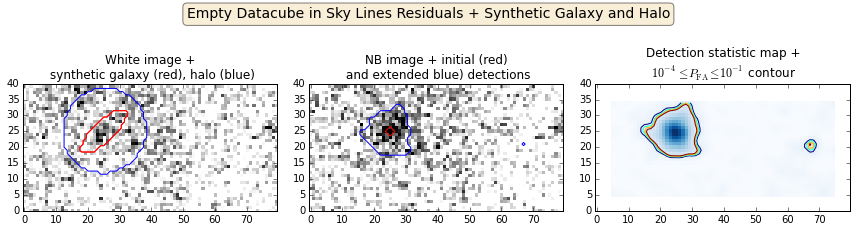

In [85]:
printhalo = True
printgal=True
################################
### Standard Empty Cube + galaxy and halo inserted

Y_src,Y_ms = get_cubes(empty_cube_all)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Standard Empty Datacube + Synthetic Galaxy and Halo')

################################
### Standard Empty Cube + galaxy and halo inserted
Y_src,Y_ms = get_cubes(empty_cube_border_all)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Empty Border Datacube + Synthesis Galaxy and Halo')

################################
### Standard Empty Cube + galaxy and halo inserted
Y_src,Y_ms = get_cubes(empty_cube_sky_all)
params = parameters.Params(Y_ms,centre, pfa_bright=pfa_bright, pfa_faint=pfa_faint, FWHM=fwhm_courant,confident=confident)
res, val, ests, X_init, val_init = sd.detection_strategy(params)

afficher('Empty Datacube in Sky Lines Residuals + Synthetic Galaxy and Halo')
